In [1]:
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid, mkvc
from ipywidgets import *

# Setup:

Sphere in a wholespace with a constant, uniform electric field

Parameters:

 - sigma_0 : conductivity of the background
 - sigma_1 : conductivity of the sphere

http://www.3ptscience.com/app/DCresistivity

# Parameters for the sphere Problem


In [11]:
sig0 = 10.          # conductivity of the wholespace
sig1 = 100.         # conductivity of the sphere
R    = 50.          # radius of the sphere
E0   = 1.           # inducing field strength
n = 100             #level of discretisation
xr = np.linspace(-2.*R, 2.*R, n) # X-axis discretization
yr = xr.copy()      # Y-axis discretization
dx = xr[1]-xr[0]       # mesh spacing
dy = yr[1]-yr[0]       # mesh spacing
zr = np.r_[0]          # identical to saying `zr = np.array([0])`
XYZ = ndgrid(xr,yr,zr) # Space Definition

In [12]:
# Radius function and useful sigma ratio
r  = lambda x,y,z: np.sqrt(x**2.+y**2.+z**2.)
sigf = lambda sig0,sig1: (sig1-sig0)/(sig1+2.*sig0)

In [13]:
# Define the conductivity for each point of the space
def get_Conductivity(XYZ,sig0,sig1,R):
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    r_view=r(x,y,z)
    
    ind0= (r_view>R)
    ind1= (r_view<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Sigma = np.zeros_like(x)
    
    Sigma[ind0] = sig0
    Sigma[ind1] = sig1
    
    return Sigma

# Potentials Computation

In [14]:
# Function that returns the total, the primary and the seconadry potentials,
# assumes an x-oriented inducing field and that the sphere is at the origin
# input: grid, outer sigma, inner sigma, radius of the sphere, strenght of the electric field

def get_Potential(XYZ,sig0,sig1,R,E0): 
    
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    
    sig_cur = sigf(sig0,sig1)
    
    r_cur = r(x,y,z)  # current radius
    
    ind0 = (r_cur > R)
    ind1 = (r_cur <= R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Vt = np.zeros_like(x)
    Vp = np.zeros_like(x)
    Vs = np.zeros_like(x)
    
    Vt[ind0] = -E0*x[ind0]*(1.-sig_cur*R**3./r_cur[ind0]**3.) # total potential outside the sphere
    Vt[ind1] = -E0*x[ind1]*3.*sig0/(sig1+2.*sig0)             # inside the sphere
    
    
    Vp = - E0*x  # primary potential
    
    Vs = Vt - Vp # secodary potential
    
    return Vt,Vp,Vs

In [15]:
#def get_Primary_Potential(XYZ,sig0,sig1,R,E0):
#   x = XYZ[:,0]
#   return - E0*x

<function __main__.plot_Potentials>

/Users/sannat/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


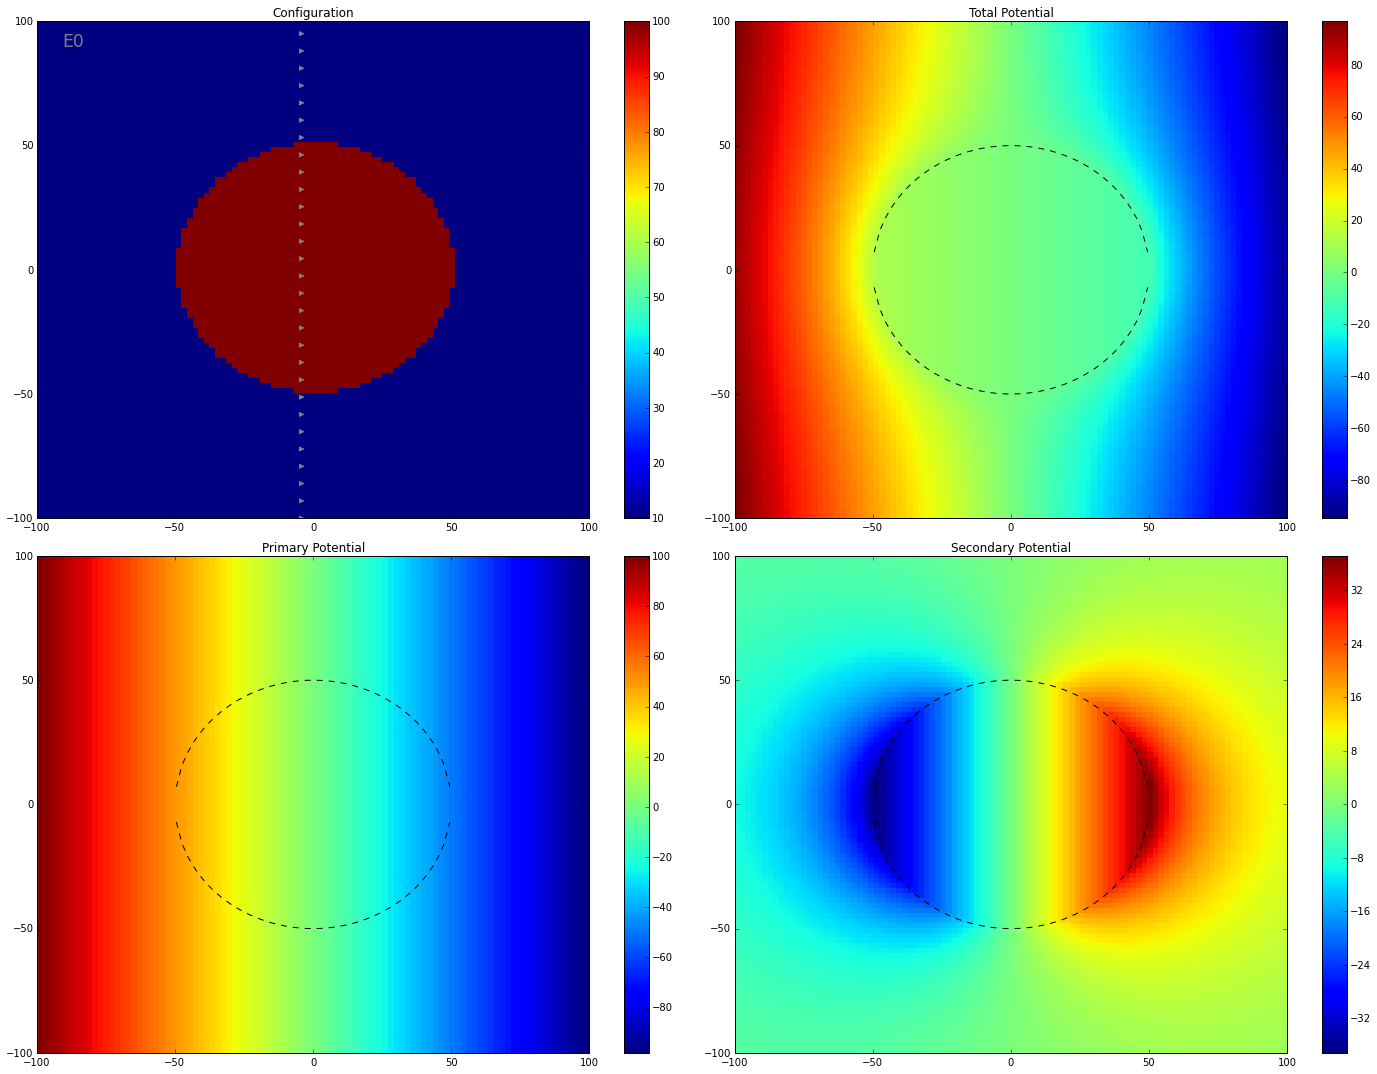

In [16]:
# Interactive tool to visualise the primary, secondary and total potentials

R_slider  = FloatSlider(min=0., max =50., step=10.,value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=1.,value=1.)

def plot_Potentials(R,sig1,sig0,E0):
    Sigma    = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    
    Ep = np.zeros(shape=(len(Sigma),3))
    Ep[:,0] = E0
    #Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])


    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential')
    plt.colorbar(ax[1].pcolor(xr,yr,Vp.reshape(xr.size, yr.size)),ax=ax[1])

    ax[2].pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Potential')
    plt.colorbar(ax[2].pcolor(xr,yr,Vt.reshape(xr.size, yr.size)),ax=ax[2])


    ax[3].pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential')
    plt.colorbar(ax[3].pcolor(xr,yr,Vs.reshape(xr.size, yr.size)),ax=ax[3])


    plt.tight_layout()
    
interact(plot_Potentials, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider)

# Electric Field Computation

In [17]:
# Function that returns the total, the primary and the seconadry electric fields, 
# input: grid, outer sigma, inner sigma, radius of the sphere, strenght of the electric field

def get_ElectricField (XYZ,sig0,sig1,R,E0):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)  # current radius
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
        
    Ep = np.zeros(shape=(len(x),3))
    Ep[:,0] = E0
    
    Et = np.zeros(shape=(len(x),3))
    
    Et[ind0,0] = E0 + E0*R**3./(r_cur[ind0]**5.)*sigf(sig0,sig1)*(2.*x[ind0]**2.-y[ind0]**2.-z[ind0]**2.);
    Et[ind0,1] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*y[ind0]*sigf(sig0,sig1);
    Et[ind0,2] = E0*R**3./(r_cur[ind0]**5.)*3.*x[ind0]*z[ind0]*sigf(sig0,sig1);

    Et[ind1,0] = 3.*sig0/(sig1+2.*sig0)*E0;
    Et[ind1,1] = 0.;
    Et[ind1,2] = 0.;
    
    Es = Et - Ep
    
    return Et, Ep, Es


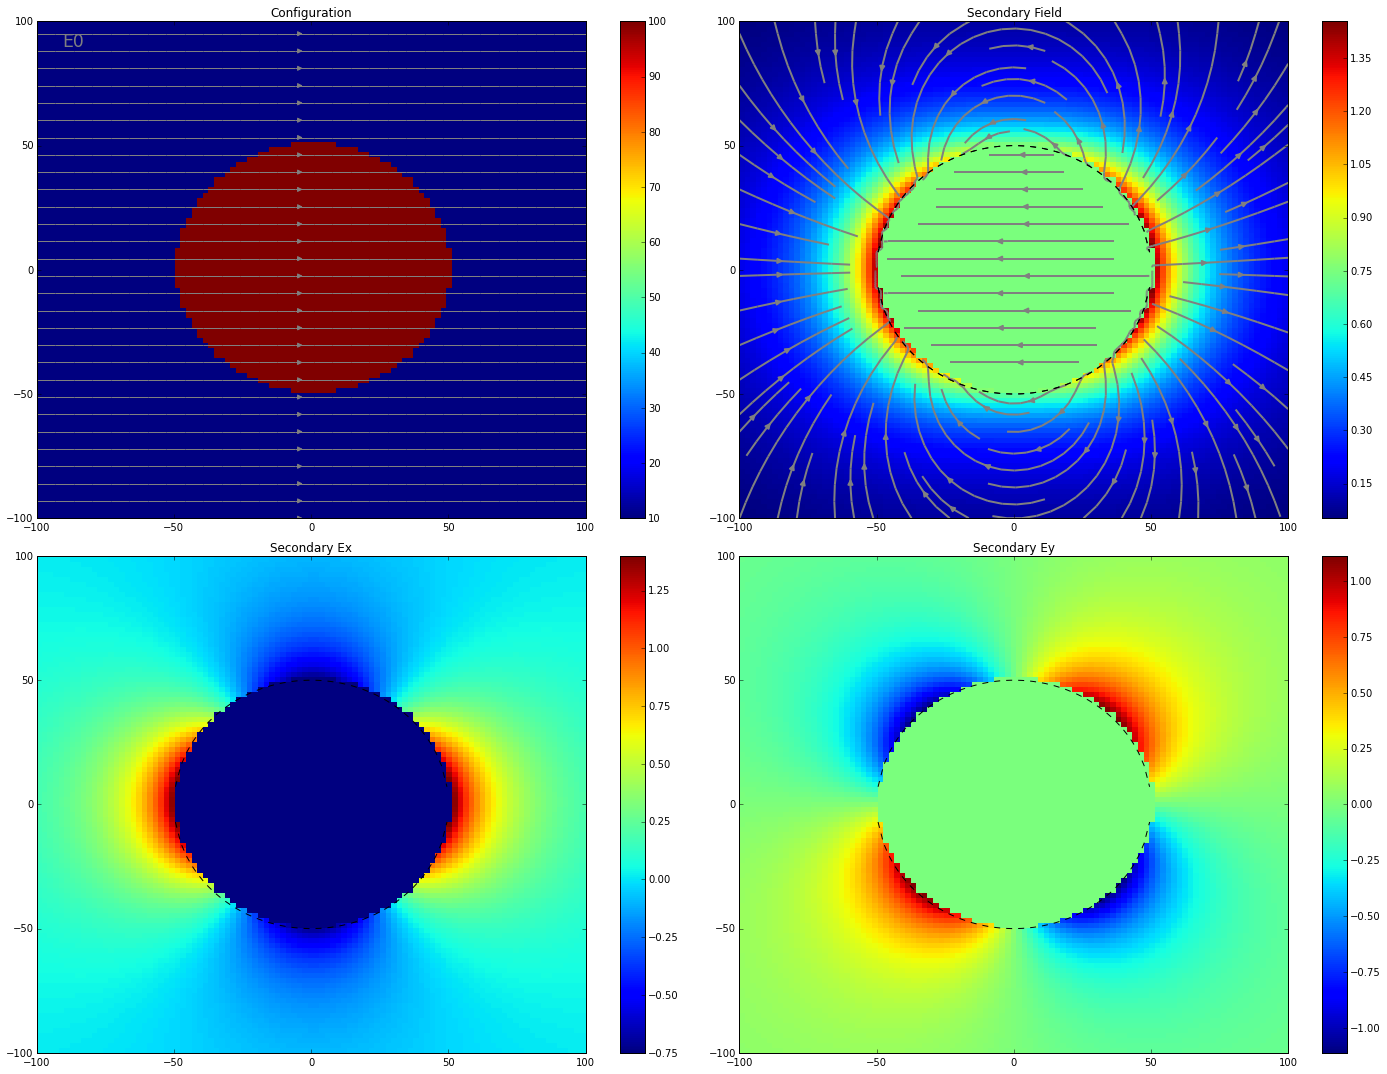

In [18]:
# Interavtice visualisation of the Electric Field

R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)
PlotOpt_button = ToggleButtons(options=['Total','Secondary'],value = 'Total')

#PlotOpt would need to be passed to the function in the interact. You could define something like:

#   if PlotOpt is 'total':
 #         Jplot = Jtotal
# elif PlotOpt is 'secondary':
#          Jplot = Jsecondary

def plot_ElectricField(R,sig1,sig0,E0,PlotOpt):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    
    xcirc = xr[np.abs(xr) <= R]
    
    EtXr = Et[:,0].reshape(xr.size, yr.size)
    EtYr = Et[:,1].reshape(xr.size, yr.size)
    EtZr = Et[:,2].reshape(xr.size, yr.size)
    EtAmp = np.sqrt(Et[:,0]**2+Et[:,1]**2 + Et[:,2]**2).reshape(xr.size, yr.size)
    
    ESXr = Es[:,0].reshape(xr.size, yr.size)
    ESYr = Es[:,1].reshape(xr.size, yr.size)
    ESZr = Es[:,2].reshape(xr.size, yr.size)
    EsAmp = np.sqrt(Es[:,0]**2+Es[:,1]**2+Es[:,2]**2).reshape(xr.size, yr.size)
    
    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')

    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')

    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')

    if PlotOpt == 'Total':
    
        ax[2].pcolor(xr,yr,EtAmp)
        plt.colorbar(ax[2].pcolor(xr,yr,EtAmp),ax=ax[2])
        ax[2].streamplot(xr,yr,EtXr,EtYr,color='gray',linewidth=2.)#angles='xy',scale_units='xy',scale=0.05)
        ax[2].set_title('Total Field')

        ax[1].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size))
        plt.colorbar(ax[1].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size)),ax=ax[1])
        ax[1].set_title('Total Ex')
    
        ax[3].pcolor(xr,yr,Et[:,1].reshape(xr.size,yr.size))
        plt.colorbar(ax[3].pcolor(xr,yr,Et[:,1].reshape(xr.size, yr.size)),ax=ax[3])
        ax[3].set_title('Total Ey')
    
    
    elif PlotOpt is 'Secondary':

        ax[2].pcolor(xr,yr,EsAmp)
        plt.colorbar(ax[2].pcolor(xr,yr,EsAmp),ax=ax[2])
        ax[2].streamplot(xr,yr,ESXr,ESYr,color='gray',linewidth=2.)#,angles='xy',scale_units='xy',scale=0.05)
        ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
        ax[2].set_title('Secondary Field')
        ax[2].set_xlim([xr.min(),xr.max()])
        ax[2].set_ylim([yr.min(),yr.max()])
    
        ax[1].pcolor(xr,yr,Es[:,0].reshape(xr.size, yr.size))
        plt.colorbar(ax[1].pcolor(xr,yr,Es[:,0].reshape(xr.size, yr.size)),ax=ax[1])
        ax[1].set_title('Secondary Ex')
    
        ax[3].pcolor(xr,yr,Es[:,1].reshape(xr.size,yr.size))
        plt.colorbar(ax[3].pcolor(xr,yr,Es[:,1].reshape(xr.size, yr.size)),ax=ax[3])
        ax[3].set_title('Secondary Ey')
        
    else:

        print('Oups!')
        
    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S1_slider,sig0=S0_slider,E0=E0_slider,PlotOpt = PlotOpt_button)

# Current Density

In [10]:
# Function that returns the total, the primary and the seconadry current densities, 
# input: grid, outer sigma, inner sigma, radius of the sphere, total, the primary and the seconadry electric fields, 

def get_Current(XYZ,sig0,sig1,R,Et,Ep,Es):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    
    r_cur=r(x,y,z)
    
    ind0= (r_cur>R)
    ind1= (r_cur<=R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    Jt = np.zeros(shape=(len(x),3))
    J0 = np.zeros(shape=(len(x),3))
    Js = np.zeros(shape=(len(x),3))
    

    Jp = sig0*Ep
    
    Jt[ind0,:] = sig0*Et[ind0,:]   
    Jt[ind1,:] = sig1*Et[ind1,:]

    
    Js[ind0,:] = sig0*Es[ind0,:]
    Js[ind1,:] = sig1*Es[ind1,:]
    
    return Jt,Jp,Js
    

<function __main__.plot_Currents>

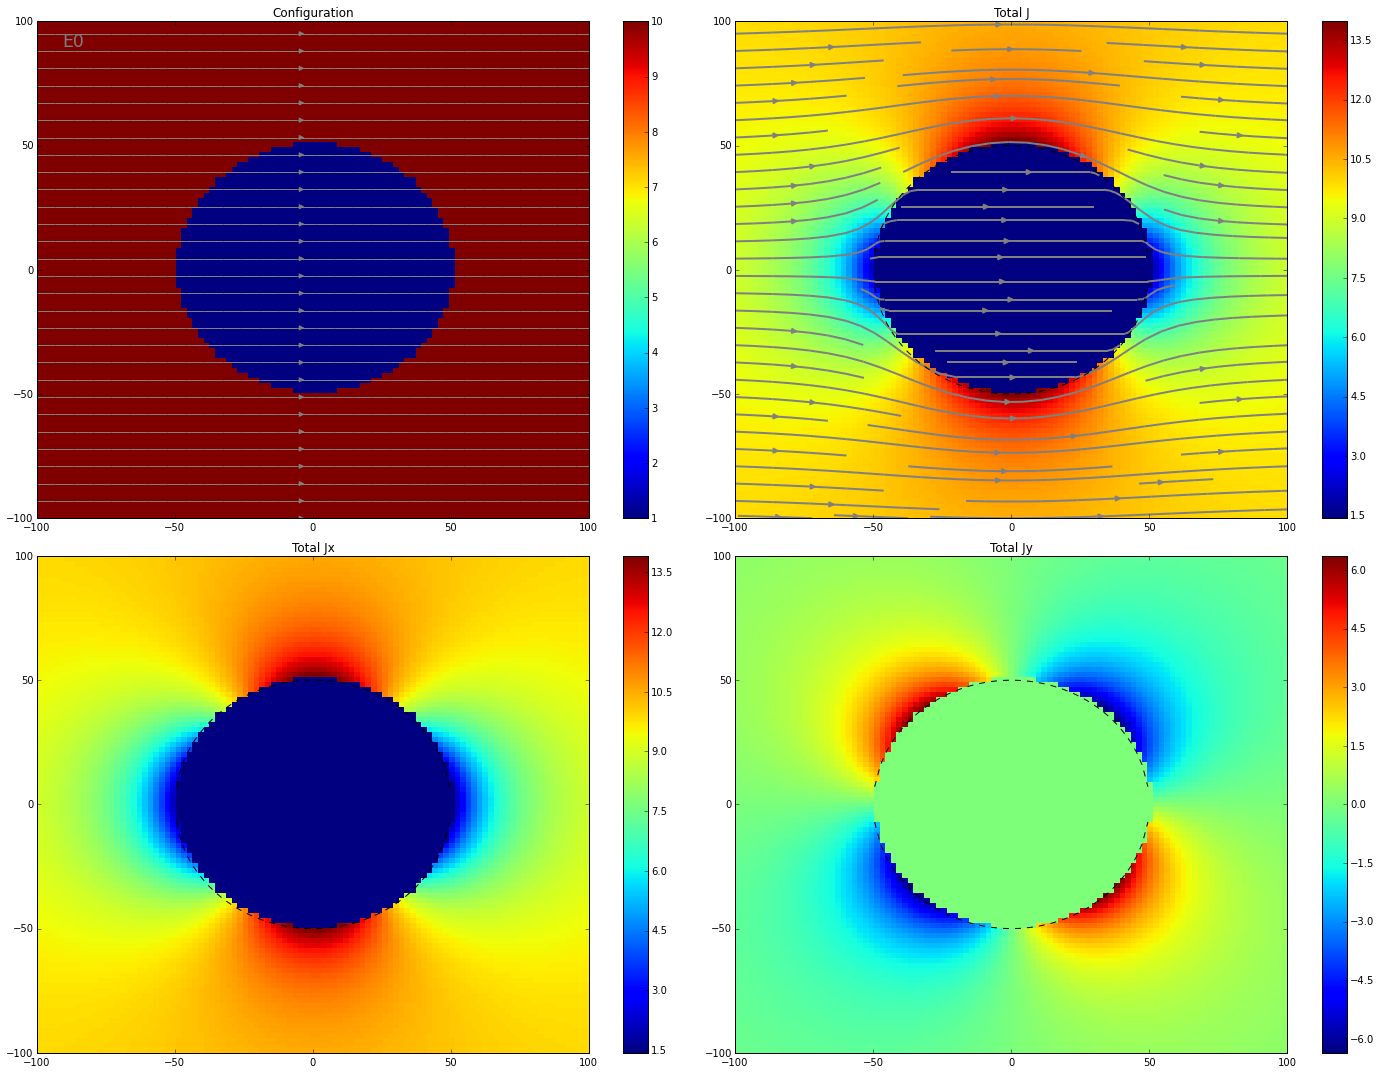

In [11]:
# Interactice visualisation of the current density
 
R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=1.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)
PlotOpt_button = ToggleButtons(options=['Total','Secondary'],value = 'Total')

def plot_Currents(R,sig1,sig0,E0,PlotOpt):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    Jt,Jp,Js = get_Current(XYZ,sig0,sig1,R,Et,Ep,Es)
    
    xcirc = xr[np.abs(xr) <= R]
    
    JtXr = Jt[:,0].reshape(xr.size, yr.size)
    JtYr = Jt[:,1].reshape(xr.size, yr.size)
    JtZr = Jt[:,2].reshape(xr.size, yr.size)
    #JtX,JtY,JtZ=JtXr[::10,::10], JtYr[::10,::10], JtZr[::10,::10]
    JtAmp = np.sqrt(Jt[:,0]**2+Jt[:,1]**2+Jt[:,2]**2).reshape(xr.size, yr.size)
    
    
    JsXr = Js[:,0].reshape(xr.size, yr.size)
    JsYr = Js[:,1].reshape(xr.size, yr.size)
    JsZr = Js[:,2].reshape(xr.size, yr.size)
    #JsX,JsY,JsZ=JsXr[::10,::10], JsYr[::10,::10], JsZr[::10,::10]
    JsAmp = np.sqrt(Js[:,1]**2+Js[:,0]**2+Jt[:,2]**2).reshape(xr.size,yr.size)
    
    fig,ax = plt.subplots(2,2,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    
    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])    
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')

    if PlotOpt == 'Total':
        
        ax[2].pcolor(xr,yr,JtAmp)
        plt.colorbar(ax[2].pcolor(xr,yr,JtAmp),ax=ax[2])
        ax[2].streamplot(xr,yr,JtXr,JtYr,color='gray',linewidth=2.)#,angles='xy',scale_units='xy',scale=1)
    
        ax[2].set_title('Total J')

        ax[1].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size))
        plt.colorbar(ax[1].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size)),ax=ax[1])
        ax[1].set_title('Total Jx')

        ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size,yr.size))
        plt.colorbar(ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size, yr.size)),ax=ax[3])
        ax[3].set_title('Total Jy')

    elif PlotOpt == 'Secondary':
        
        ax[2].pcolor(xr,yr,JsAmp)
        plt.colorbar(ax[2].pcolor(xr,yr,JsAmp),ax=ax[2])
        ax[2].streamplot(xr,yr,JsXr,JsYr,color='gray',linewidth=2.)#angles='xy',scale_units='xy',scale=1)
        ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
        ax[2].set_xlim([xr.min(),xr.max()])
        ax[2].set_ylim([yr.min(),yr.max()])
        ax[2].set_title('secondary J')
        
        ax[1].pcolor(xr,yr,Js[:,0].reshape(xr.size, yr.size))
        plt.colorbar(ax[1].pcolor(xr,yr,Jt[:,0].reshape(xr.size, yr.size)),ax=ax[1])
        ax[1].set_title('Secondary Jx')

        ax[3].pcolor(xr,yr,Js[:,1].reshape(xr.size,yr.size))
        plt.colorbar(ax[3].pcolor(xr,yr,Jt[:,1].reshape(xr.size, yr.size)),ax=ax[3])
        ax[3].set_title('Secondary Jy')
        
    else:
        print('Oups')
    
    plt.tight_layout()
    
    
interact(plot_Currents, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider,PlotOpt=PlotOpt_button)

# Charge Accumulation computation

In [19]:
def get_ChargesDensity(XYZ,sig0,sig1,R,Et,Ep):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    ind0 = (r_cur > R)
    ind1 = (r_cur < R)
    ind2 = ((r_cur < (R+dx/2)) & (r_cur > (R-dx/2)) )
    
    assert (ind0 + ind1 + ind2).all(), 'Some indicies not included'
    
    rho = np.zeros_like(x)
    
    rho[ind0] = 0
    rho[ind1] = 0
    rho[ind2] = epsilon_0*3.*Ep[ind2,0]*sigf(sig0,sig1)*x[ind2]/(np.sqrt(x[ind2]**2.+y[ind2]**2.))
    
    return rho

In [20]:
Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
rho = get_ChargesDensity(XYZ,sig0,sig1,R,Et,Ep)
print rho.shape
print Et[:,0].reshape(xr.size,yr.size).shape

(10000,)
(100, 100)


<function __main__.plot_Charges>

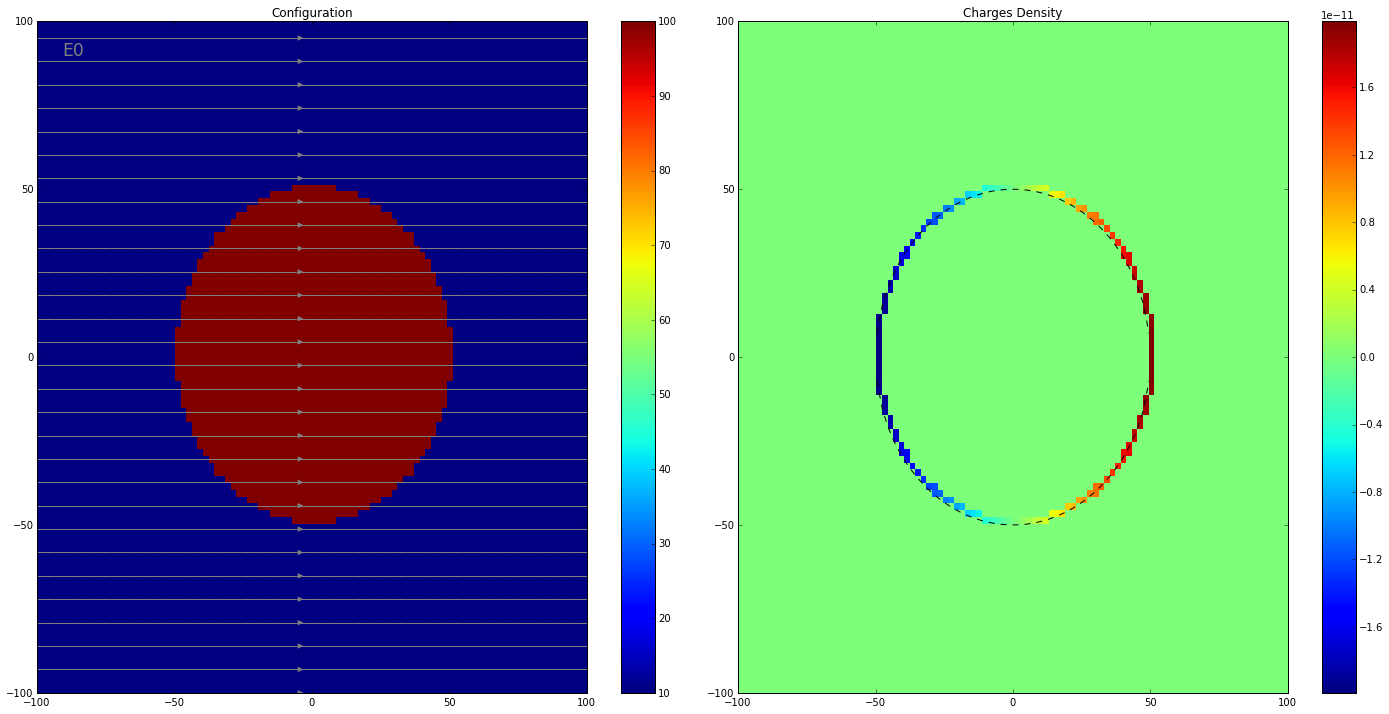

In [14]:
#Interavtice visualisation of the charge accumulation

R_slider  = FloatSlider(min=0., max =50., step=10., value=50.)
S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
E0_slider = FloatSlider(min=-10., max =10., step=2., value=1.)

def plot_Charges(R,sig0,sig1,E0):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep, Es = get_ElectricField(XYZ,sig0,sig1,R,E0)
    rho = get_ChargesDensity(XYZ,sig0,sig1,R,Et,Ep)
    
    xcirc = xr[np.abs(xr) <= R]
    
    fig,ax = plt.subplots(1,2,figsize=(20,10))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].quiver(np.zeros_like(xrr)-90,yrr,E0,0,angles='xy',scale_units='xy',scale=0.05,color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])
    ax[1].pcolor(xr,yr,rho.reshape(xr.size, yr.size))
    plt.colorbar(ax[1].pcolor(xr,yr,rho.reshape(xr.size, yr.size)),ax=ax[1])
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Charges Density')

    plt.tight_layout()
    
interact(plot_Charges, R=R_slider, sig1=S1_slider,sig0=S0_slider, E0=E0_slider)

# M-N Potential differential Measurements

In [21]:
def MN_Potential_total(XYZ,sig0,sig1,R,E0,start,end,nbmp,mn):
    
    #Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    D = np.sqrt((start[0]-end[0])**2.+(start[1]-end[1])**2.)
    
    MP = np.zeros(shape=(nbmp,2))
    MP[:,0] = np.linspace(start[0],end[0],nbmp)
    MP[:,1] = np.linspace(start[1],end[1],nbmp)
    
    EL = np.zeros(shape=(2*nbmp,2))
    
    for n in range(0,len(EL),2):
        EL[n,0]   = MP[n/2,0] - ((end[0]-start[0])/D)*mn/2.
        EL[n+1,0] = MP[n/2,0] + ((end[0]-start[0])/D)*mn/2.
        EL[n,1]   = MP[n/2,1] - ((end[1]-start[1])/D)*mn/2.
        EL[n+1,1] = MP[n/2,1] + ((end[1]-start[1])/D)*mn/2.
    
    VtEL = np.zeros(2*nbmp)
    VsEL = np.zeros(2*nbmp)
    VtdMP = np.zeros(nbmp)
    VtdMPn = np.zeros(nbmp)
    VsdMP = np.zeros(nbmp)
    VsdMPn = np.zeros(nbmp)
    
    for m in range(0,2*nbmp):
        
        if (r(EL[m,0],EL[m,1],0) > R):
            VtEL[m] = -E0*EL[m,0]*(1.-sigf(sig0,sig1)*R**3./r(EL[m,0],EL[m,1],0)**3.)
        
        else:
            VtEL[m] = -E0*EL[m,0]*3.*sig0/(sig1+2.*sig0)
    
    VsEL = VtEL - E0*EL[:,0]
       
    for p in range(0,nbmp):
        VtdMP[p] = VtEL[2*p]-VtEL[2*p+1]
        VtdMPn[p] = VtdMP[p]/mn
        VsdMP[p] = VsEL[2*p]-VsEL[2*p+1]
        VsdMPn[p] = VsdMP[p]/mn
    
    return MP,EL,VtdMP,VtdMPn,VsdMP,VsdMPn

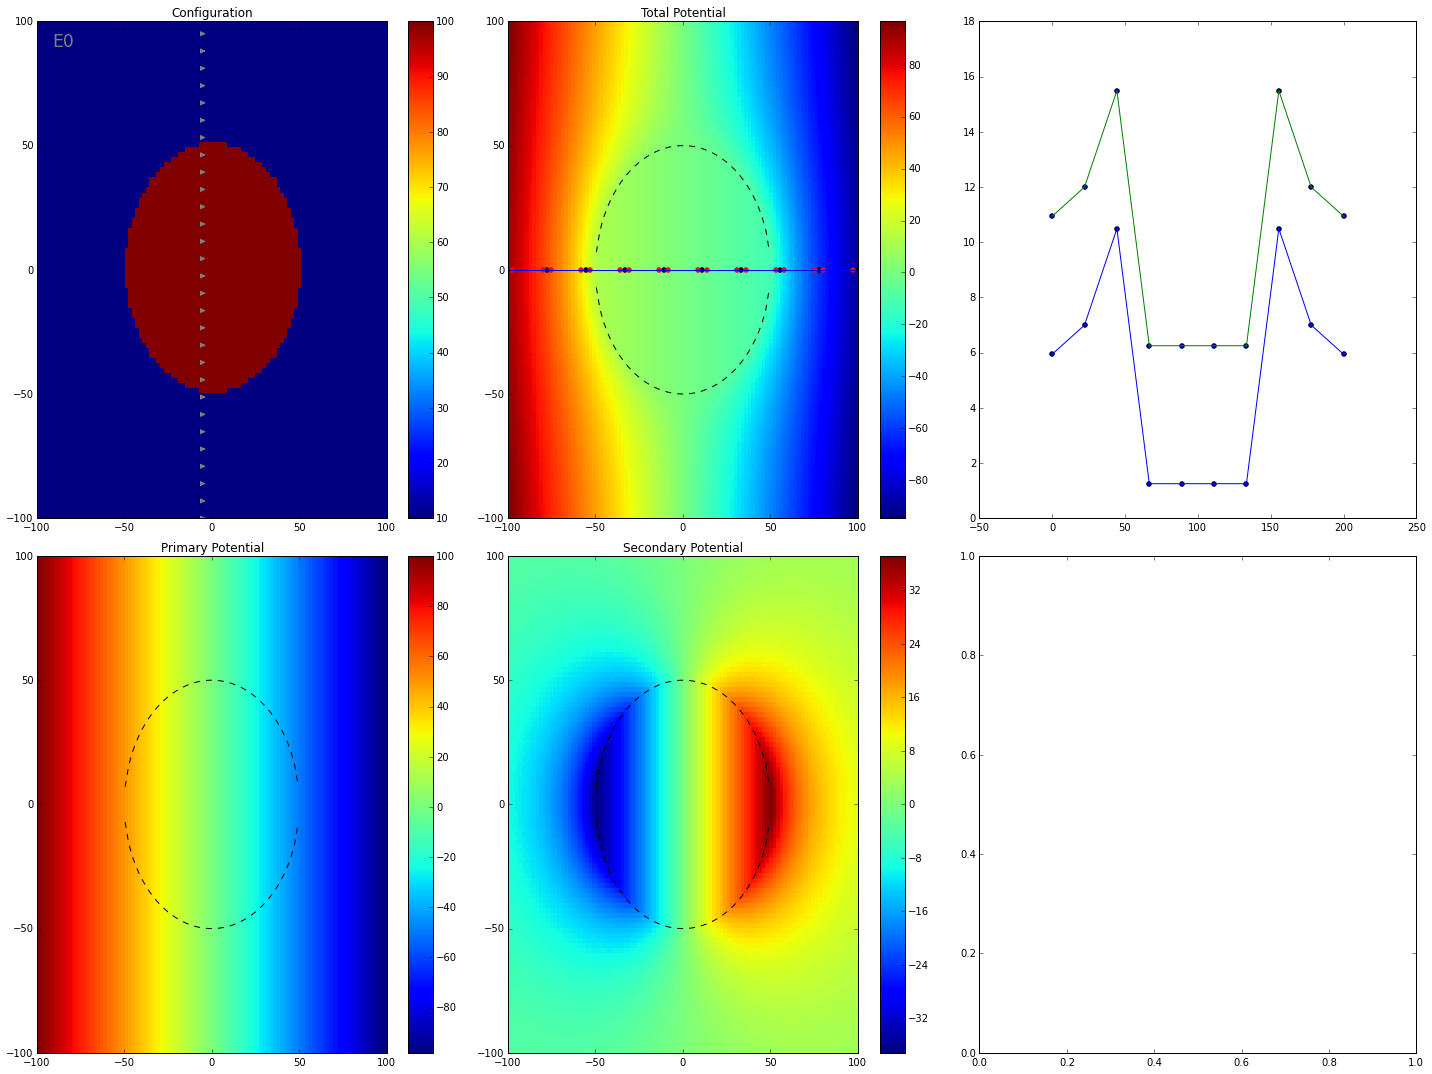

In [22]:
# Interactive tool to visualise the primary, secondary and total potentials

#R_slider  = FloatSlider(min=0., max =50., step=10.,value=50.)
#S1_slider = FloatSlider(min=1., max =100., step=1.,value=100.)
#S0_slider = FloatSlider(min=1., max =100., step=1.,value=10.)
#E0_slider = FloatSlider(min=-10., max =10., step=1.,value=1.)

start=[-100,0]
end=[100,0]
nbmp=10
mn=5

def plot_PotentialDifferences(XYZ,sig0,sig1,R,E0,start,end,nbmp,mn):
    Sigma    = get_Conductivity(XYZ,sig0,sig1,R)
    Vt,Vp,Vs = get_Potential(XYZ,sig0,sig1,R,E0)
    MP,EL,VtdMP,VtdMPn,VsdMP,VsdMPn = MN_Potential_total(XYZ,sig0,sig1,R,E0,start,end,nbmp,mn)
    
    Ep = np.zeros(shape=(len(Sigma),3))
    Ep[:,0] = E0
    #Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(2,3,figsize=(20,15))
    ax=mkvc(ax)

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].streamplot(xr,yr,Ep[:,0].reshape(xr.size,yr.size),Ep[:,1].reshape(xr.size,yr.size),color='gray')
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')
    ax[0].annotate('E0',(-90,90),xytext=(-90,90),fontsize='xx-large',color='gray')
    ax[0].set_xlim([xr.min(),xr.max()])
    ax[0].set_ylim([yr.min(),yr.max()])
    plt.colorbar(ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size)),ax=ax[0])


    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential')
    plt.colorbar(ax[1].pcolor(xr,yr,Vp.reshape(xr.size, yr.size)),ax=ax[1])
    ax[1].set_xlim([xr.min(),xr.max()])
    ax[1].set_ylim([yr.min(),yr.max()])

    ax[2].pcolor(xr,yr,Vt.reshape(xr.size,yr.size))
    plt.colorbar(ax[2].pcolor(xr,yr,Vt.reshape(xr.size, yr.size)),ax=ax[2])
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].plot(MP[:,0],MP[:,1])
    ax[2].set_title('Total Potential')
    ax[2].scatter(MP[:,0],MP[:,1],color='black')
    ax[2].scatter(EL[:,0],EL[:,1],color='red')
    ax[2].set_xlim([xr.min(),xr.max()])
    ax[2].set_ylim([yr.min(),yr.max()])


    ax[3].pcolor(xr,yr,Vs.reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential')
    plt.colorbar(ax[3].pcolor(xr,yr,Vs.reshape(xr.size, yr.size)),ax=ax[3])
    ax[3].set_xlim([xr.min(),xr.max()])
    ax[3].set_ylim([yr.min(),yr.max()])

    ax[4].plot(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VtdMP)#,np.sqrt(MP[:,0]**2+MP[:,1]**2),VdMPn)
    ax[4].scatter(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VtdMP)
    ax[4].plot(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VsdMP)#,np.sqrt(MP[:,0]**2+MP[:,1]**2),VdMPn)
    ax[4].scatter(np.sqrt((MP[0,0]-MP[:,0])**2+(MP[:,1]-MP[0,1])**2),VsdMP)

    plt.tight_layout()
    
#interact(plot_PotentialDifferences, R=R_slider, sig1=S1_slider, sig0=S0_slider,E0=E0_slider)
plot_PotentialDifferences(XYZ,sig0,sig1,R,E0,start,end,nbmp,mn)